# Laboratorium 4.

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

#### Generowanie linii oraz zapis do pliku 
##### (Linie mogą być również wyznaczane ręcznie przy pomocy funkcji "Dodaj linię")

In [3]:
import random
def generateLines(n, minx,maxx,miny,maxy):
    lines = [[(random.uniform(minx, maxx),random.uniform(miny, maxy)), (random.uniform(minx, maxx),random.uniform(miny, maxy))] for i in range(n)]
    for line in lines:
        if line[0][0]==line[1][0]:
            line[1] = (line[1][0]+0.0001, line[1][1])
        for line2 in lines:
            if line[0][0] == line2[0][0]:
                line[0] = (line[0][0]+0.00001, line[0][1])
            if line[0][0] == line2[1][0]:
                line[0] = (line[0][0]+0.00001, line[0][1])
            if line[1][0] == line2[0][0]:
                line2[0] = (line2[0][0]+0.00001, line2[0][1])
            if line[1][0] == line2[1][0]:
                line2[0] = (line2[0][0]+0.00001, line2[0][1])
            
    return lines

def saveToJson(Data, Name):
    with open(Name+".json", "w") as write_file:
        write_file.write(js.dumps(Data))
        
def loadFromJson(Name): 
    with open(Name+".json", "r") as read_file:
        A = js.load(read_file)
    return A


#### Funckje pomocnicze

In [4]:
import bintrees

In [5]:
B = 0
E = 1
I = 2

def det(a,b,c):
     return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-c[1]*a[0]-b[0]*a[1]
    
    
def intersectionPoint(line1,line2):
    (xa,ya),(xb,yb) = line1
    a1 = (ya-yb)/(xa-xb)
    b1 = ya -a1*xa
    (xa,ya),(xb,yb) = line2
    a2 = (ya-yb)/(xa-xb)
    b2 = ya -a2*xa
    W = a2-a1
    if W ==0:
        return None
    Wx = b1-b2
    Wy = a2*b1 - a1*b2
    x = Wx/W
    y = Wy/W
    return x,y
    
def intersection(line1,line2):
    if det(line1[0],line1[1],line2[0]) * det(line1[0],line1[1],line2[1]) <= 0 and det(line2[0],line2[1],line1[0]) * det(line2[0],line2[1],line1[1]) <= 0:
        return intersectionPoint(line1,line2)
    return None

def getY(line, x):
    (xa,ya),(xb,yb) = line
    a = (ya-yb)/(xa-xb)
    b = ya-a*xa   
    return a*x +b

def linesToPoints(lines):
    res = []
    for line in lines:
        res.append(line[0])
        res.append(line[1])
    return res

def treeToLines(T):
    res =[]
    for val in T.values():
        res.append(val[0])
    return res

def dictToLines(D):
    res = []
    for item in D.items():
        res.append(item[1])
    return res

def getMinMaxY(lines):
    miny = maxy = 0
    for line in lines:
        miny = min(miny, line[0][1], line[1][1])
        maxy = max(maxy, line[0][1], line[1][1])
    return miny,maxy


#### Algorytm sprawdzający czy istnieje przynajmniej jedno przecięcie

In [6]:
def anyIntersection(lines):

    Q = bintrees.RBTree()
    for line in lines:
        if line[0][0] > line[1][0]:
            line[0],line[1] = line[1], line[0]
        Q.insert(line[0][0], (line, B))
        Q.insert(line[1][0], (line, E))
    

    T = bintrees.RBTree()
    lastX = None
    while not Q.is_empty():
        line = Q.pop(min(Q))
        
        if line[1]==B:
            key = line[0][0][1]
            T.insert(key, line)
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], line[0][0][0]), val)
            T = NT
            T.insert(key, line)
            lastX = line[0][0][0]
            
        elif line[1]==E:
            key = getY(line[0], lastX)
            T.remove(key)
   
        else:
            
            lastX =line[0][0]
            lastX = lastX+ 0.0000001
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], lastX), val)
            T = NT

        
        for item in T.items():
            nb = None
            try:
                nb = T.succ_item(item[0])
            except:
                nb = None
            if nb is not None:
                point = intersection(item[1][0], nb[1][0])
                if point is not None:
                    return True
                       
        
    return False
 

In [7]:
def anyIntersectionVis(lines):

    Q = bintrees.RBTree()
    res = {}
    for line in lines:
        if line[0][0] > line[1][0]:
            line[0],line[1] = line[1], line[0]
        Q.insert(line[0][0], (line, B))
        Q.insert(line[1][0], (line, E))
    
    points = linesToPoints(lines)
    scenes = [Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines)])]
    
    miny, maxy = getMinMaxY(lines)
    broom = [[(0,0),(0,0)]]

    T = bintrees.RBTree()
    lastX = None
    while not Q.is_empty():
        line = Q.pop(min(Q))
        
        if line[1]==B:
            key = line[0][0][1]
            T.insert(key, line)
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], line[0][0][0]), val)
            T = NT
            lastX = line[0][0][0]
            
            broom =[[(lastX,miny),(lastX,maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
                
        elif line[1]==E:
            key = getY(line[0], lastX)

            T.remove(key)
            
            broom =[[(line[0][1][0],miny),(line[0][1][0],maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
       
   
        else:
            
            lastX =line[0][0]
            lastX = lastX + 0.0000001
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], lastX), val)
            T = NT

            broom =[[(line[0][0],miny),(line[0][0],maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
       
            

        for item in T.items():
            nb = None
            try:
                nb = T.succ_item(item[0])
            except:
                nb = None
            if nb is not None:
                point = intersection(item[1][0], nb[1][0])
                if point is not None:
                    res[point] = point
                    scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                                    [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
                    return True, scenes
                       
        
    return False, scenes
 

<IPython.core.display.Javascript object>


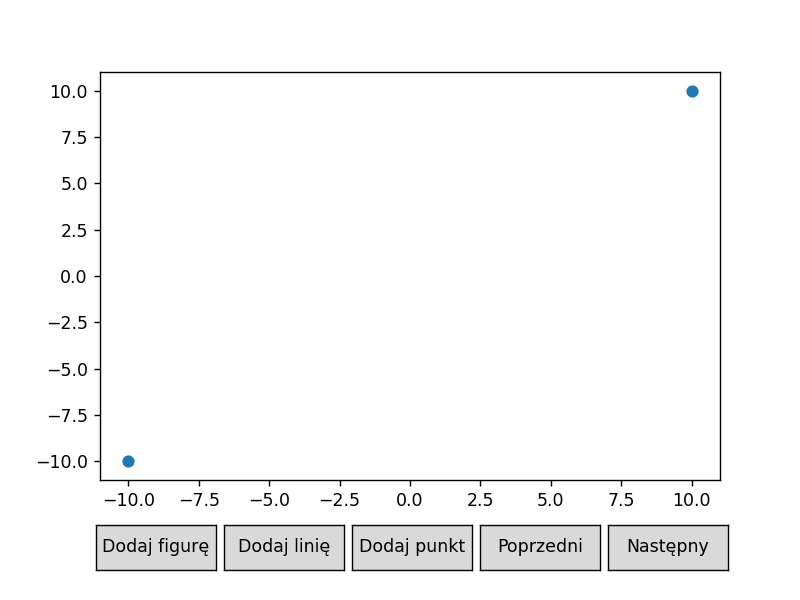

In [8]:
%matplotlib notebook
plot2 =Plot(points=[PointsCollection([[-10,-10],[10,10]])])
plot2.draw()

In [45]:
lines = plot2.get_added_lines()[-1].lines
#saveToJson(lines, "plot2lines")
#lines =loadFromJson( "plot2lines")
res, scenes = anyIntersectionVis(lines)

False


<IPython.core.display.Javascript object>


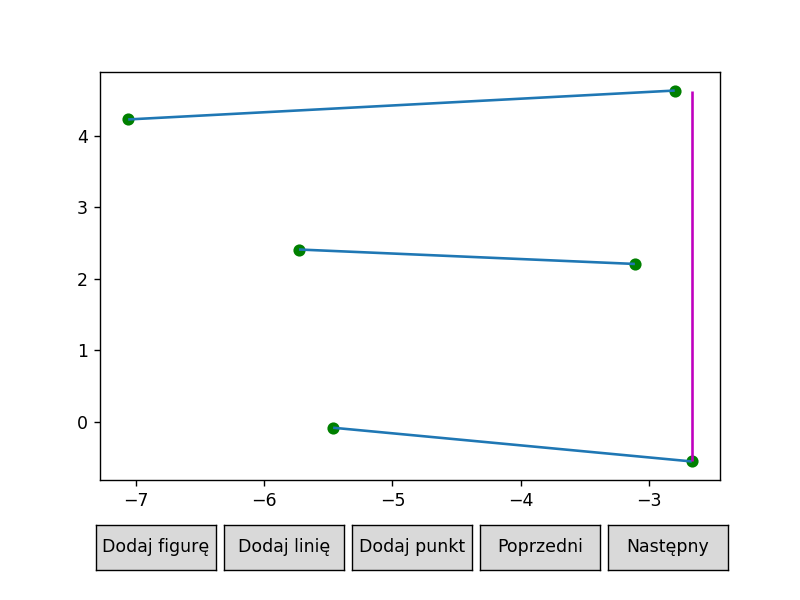

In [40]:
%matplotlib notebook
print(res)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


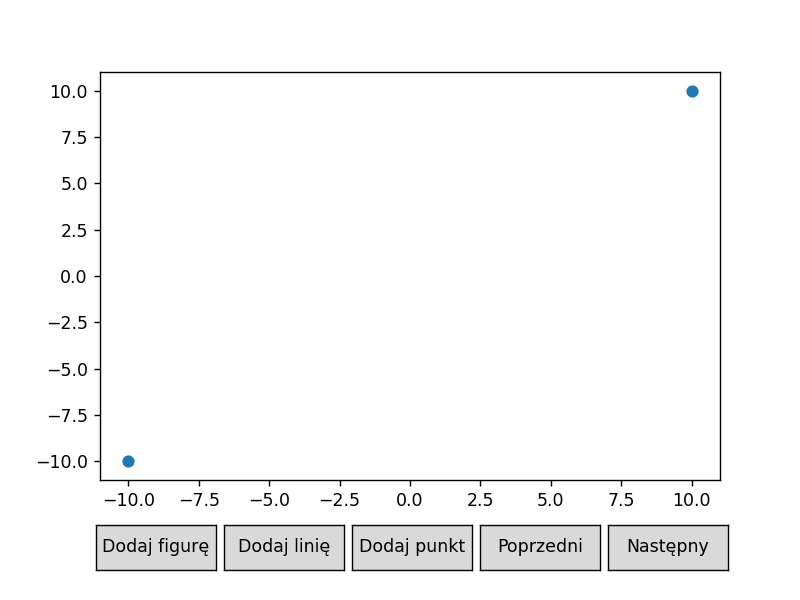

In [11]:
%matplotlib notebook
plot3 =Plot(points=[PointsCollection([[-10,-10],[10,10]])])
plot3.draw()

In [37]:
lines = plot3.get_added_lines()[-1].lines
#saveToJson(lines, "plot3lines")
#lines =loadFromJson( "plot3lines")
res, scenes = anyIntersectionVis(lines)

True


<IPython.core.display.Javascript object>


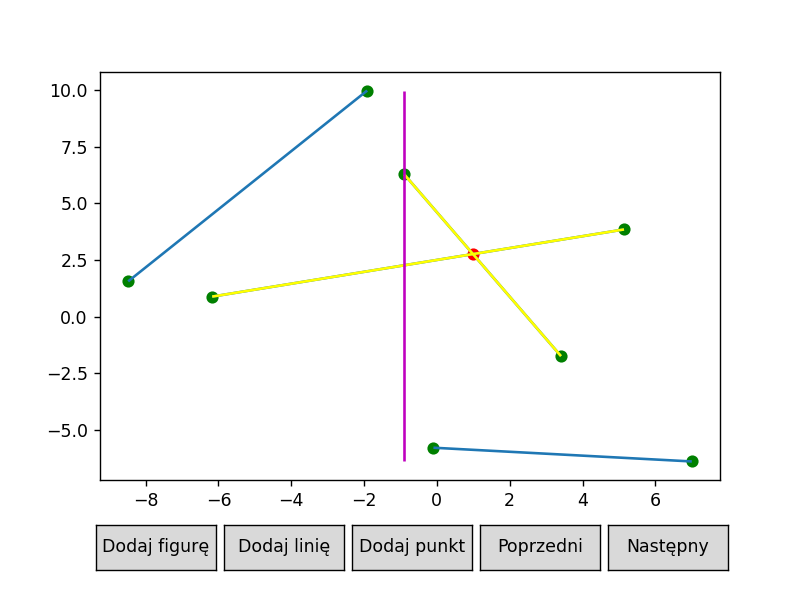

In [38]:
%matplotlib notebook
print(res)
plot = Plot(scenes=scenes)
plot.draw()

#### Algorytm wyznaczający wszystkie przecięcia 

In [21]:
def linesIntersection(lines):

    Q = bintrees.RBTree()
    res = {}
    for line in lines:
        if line[0][0] > line[1][0]:
            line[0],line[1] = line[1], line[0]
        Q.insert(line[0][0], (line, B))
        Q.insert(line[1][0], (line, E))
        
    lineRes = []

    T = bintrees.RBTree()
    lastX = None
    while not Q.is_empty():
        line = Q.pop(min(Q))
        
        if line[1]==B:
            key = line[0][0][1]
            T.insert(key, line)
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], line[0][0][0]), val)
            T = NT
            lastX = line[0][0][0]
               


        elif line[1]==E:
            key = getY(line[0], lastX)
            T.remove(key)
            

            
        else:
            
            lastX =line[0][0]
            lastX = lastX+ 0.0000001
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], lastX), val)
            T = NT
            
        
        for item in T.items():
            nb = None
            try:
                nb = T.succ_item(item[0])
            except:
                nb = None
            if nb is not None:
                point = intersection(item[1][0], nb[1][0])
                if point is not None:
                    if res.get(point) is None:
                        Q.insert(point[0], (point, I, item[1][0], nb[1][0]))
                        lineRes.append([item[1][0], nb[1][0]])
                        res[point] = point  
                       

            
    
    return len(list(res.values())), list(res.values()), lineRes, scenes

In [22]:
def linesIntersectionVis(lines):

    Q = bintrees.RBTree()
    res = {}
    for line in lines:
        if line[0][0] > line[1][0]:
            line[0],line[1] = line[1], line[0]
        Q.insert(line[0][0], (line, B))
        Q.insert(line[1][0], (line, E))
    
    points = linesToPoints(lines)
    scenes = [Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines)])]
    
    miny, maxy = getMinMaxY(lines)
    broom = [[(0,0),(0,0)]]
    T = bintrees.RBTree()
    lastX = None
    lineRes = []
    while not Q.is_empty():
        line = Q.pop(min(Q))
        
        if line[1]==B:
            key = line[0][0][1]
            T.insert(key, line)            
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], line[0][0][0]), val)
            T = NT
            lastX = line[0][0][0]
            
            broom =[[(lastX,miny),(lastX,maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
                
        elif line[1]==E:
            key = getY(line[0], lastX)
            T.remove(key)
            
            broom =[[(line[0][1][0],miny),(line[0][1][0],maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            
        else:
            
            lastX =line[0][0]
            lastX = lastX+ 0.0000001
            NT = bintrees.RBTree()
            for val in T.values():
                NT.insert(getY(val[0], lastX), val)
            T = NT

                    
            broom =[[(line[0][0],miny),(line[0][0],maxy)]]
            if res:
                scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
            else:
                scenes.append(Scene([PointsCollection(points, color = "green")], 
                        [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))

        
        
        for item in T.items():
            nb = None
            try:
                nb = T.succ_item(item[0])
            except:
                nb = None
            if nb is not None:
                point = intersection(item[1][0], nb[1][0])
                if point is not None:
                    if res.get(point) is None:
                        Q.insert(point[0], (point, I, item[1][0], nb[1][0]))
                        lineRes.append([item[1][0], nb[1][0]])
                        res[point] = point  
                        scenes.append(Scene([PointsCollection(points, color = "green"), PointsCollection(dictToLines(res), color = "red")], 
                                    [LinesCollection(lines), LinesCollection(treeToLines(T), color = "yellow"), LinesCollection(broom, color = "m")]))
 

    
    return len(list(res.values())), list(res.values()), lineRes, scenes

<IPython.core.display.Javascript object>


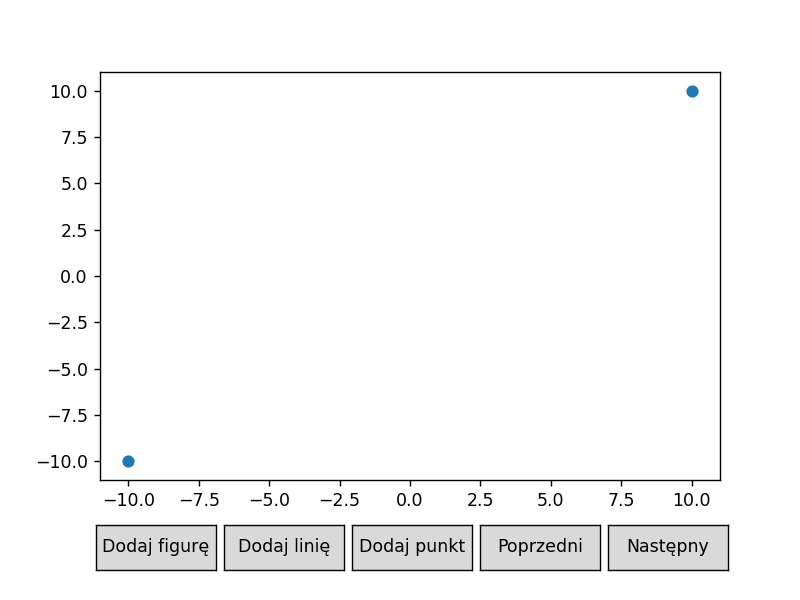

In [23]:
%matplotlib notebook
plot4 =Plot(points=[PointsCollection([[-10,-10],[10,10]])])
plot4.draw()

In [47]:
lines = plot4.get_added_lines()[-1].lines
#saveToJson(lines, "plot4lines")
#lines =loadFromJson( "plot4lines")
length, res, lineRes, scenes = linesIntersectionVis(lines)

5
[(-1.3691239279116538, 1.053668788932456), (0.9090088784500151, -0.6237314025315382), (1.8115092618459316, 3.7145182395426666), (2.705084016730587, -1.9461902040651922), (4.181182935123176, 5.6969363668419675)]
[[[[-7.354334923528857, -3.9534302505792382], [5.3755037861485615, 6.696079553342333]], [[-7.842238149335308, 5.819854063146256], [5.065019915180821, -3.6838224074419816]]], [[[0.23034249582598143, -3.8860282897949237], [2.403729592600177, 6.561275631773707]], [[-7.842238149335308, 5.819854063146256], [5.065019915180821, -3.6838224074419816]]], [[[0.23034249582598143, -3.8860282897949237], [2.403729592600177, 6.561275631773707]], [[-7.354334923528857, -3.9534302505792382], [5.3755037861485615, 6.696079553342333]]], [[[2.2263102377614654, -4.425243976069433], [4.6214715280840455, 7.976716808244294]], [[-7.842238149335308, 5.819854063146256], [5.065019915180821, -3.6838224074419816]]], [[[2.2263102377614654, -4.425243976069433], [4.6214715280840455, 7.976716808244294]], [[-7.354

<IPython.core.display.Javascript object>


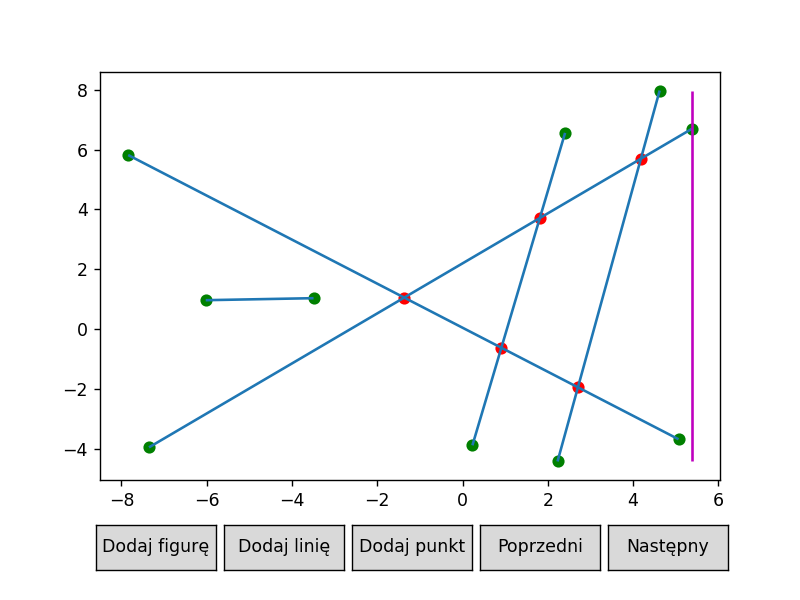

In [48]:
%matplotlib notebook
print(length)
print(res)
print(lineRes)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


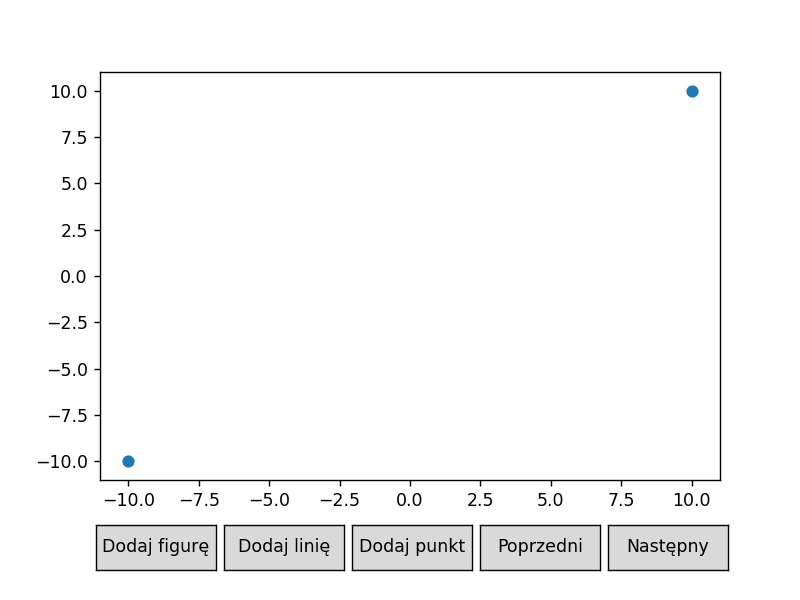

In [28]:
%matplotlib notebook
plot5 =Plot(points=[PointsCollection([[-10,-10],[10,10]])])
plot5.draw()

In [49]:
lines = plot5.get_added_lines()[-1].lines
#saveToJson(lines, "plot5lines")
#lines =loadFromJson( "plot5lines")
length, res, lineRes, scenes = linesIntersectionVis(lines)

<IPython.core.display.Javascript object>


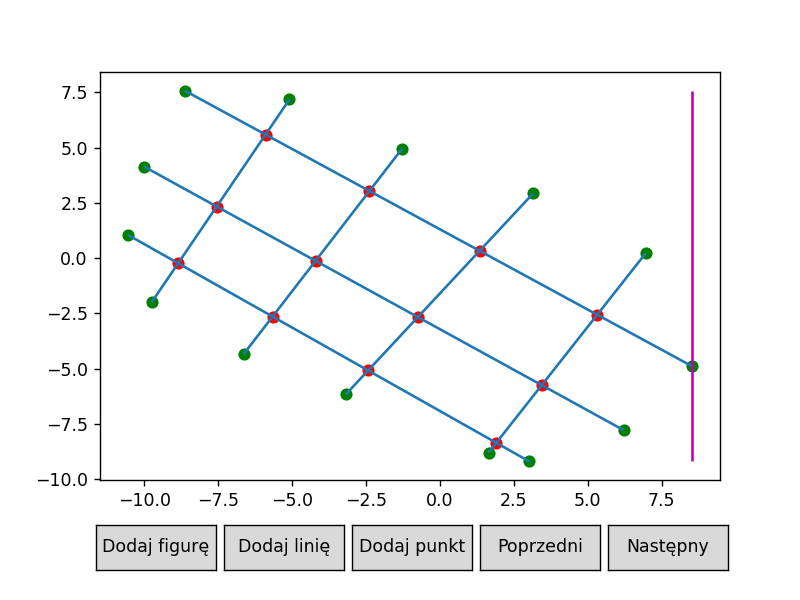

In [50]:
%matplotlib notebook
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


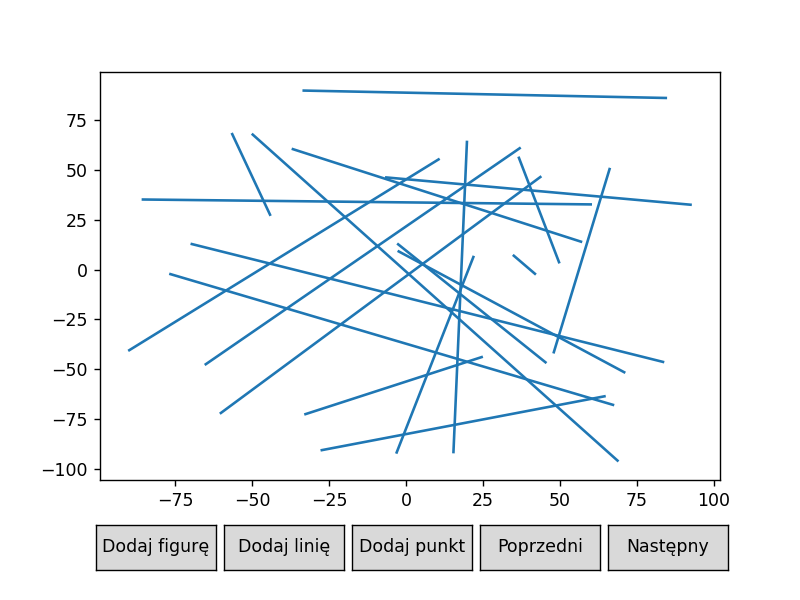

In [51]:
%matplotlib notebook
lines = generateLines(20,-100,100,-100,100)
plot6 =Plot(lines=[LinesCollection(lines)])
plot6.draw()

In [52]:
length, res, lineRes, scenes = linesIntersectionVis(lines)

<IPython.core.display.Javascript object>


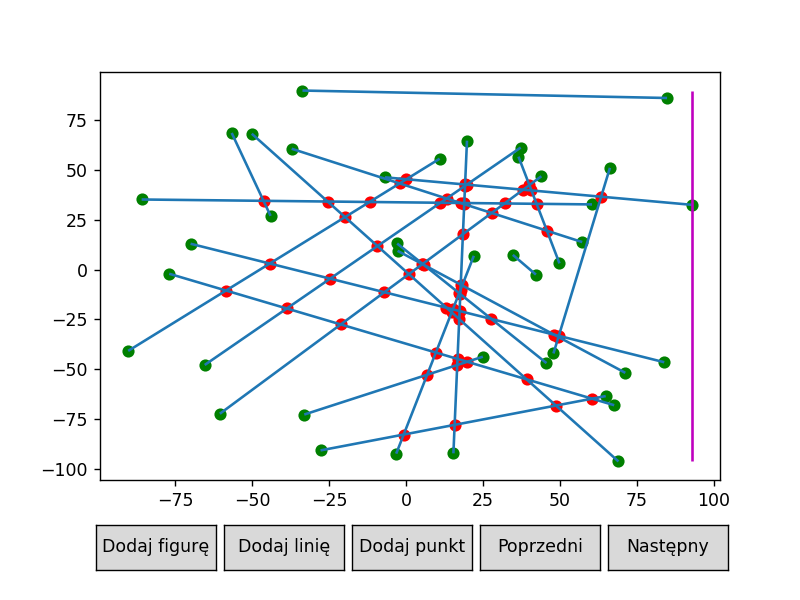

In [53]:
%matplotlib notebook
plot = Plot(scenes=scenes)
plot.draw()